# Grid sag

#### Demonstrates the use of the `grid sag` surface in PAOS


First let's create a grid sag defined by Zernike polynomials on an elliptical aperture.


In [18]:
import os
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

from paos import WFO
from paos.core.run import push_results
from paos.core.plot import simple_plot
from paos.core.parseConfig import parse_config
from paos.core.raytrace import raytrace
from paos.core.run import run

from skimage.transform import rescale

In [19]:
from skimage.measure import label, regionprops


def mask_to_elliptical_aperture(
    label_img: np.ndarray,
):
    """Convert an elliptical mask to a photutils EllipticalAperture.

    Args:
        label_img: Labeled image array where each region has a unique integer value

    Returns:
        params: Dictionary with keys 'x0', 'y0', 'a', 'b', and 'theta' representing the
            center coordinates, semi-major and semi-minor axes, and orientation of the ellipse.

    Raises:
        ValueError: If no regions found in mask
    """
    props = regionprops(label_img)
    if len(props) == 0:
        raise ValueError("No regions found in mask")

    prop = props[0]
    y0, x0 = prop.centroid
    a = prop.major_axis_length / 2
    b = prop.minor_axis_length / 2
    theta = prop.orientation  # in radians

    # Convert to photutils convention (angle in radians counter-clockwise from positive x-axis)
    theta = np.pi / 2 - theta

    params = {
        "x0": x0,
        "y0": y0,
        "a": a,
        "b": b,
        "theta": theta,
    }

    return params

Define beam and propagation parameters


In [20]:
beam_diameter = 1.1
semimaj = beam_diameter / 2
semimin = beam_diameter / 2 / 1.1 * 0.73
grid_size = 1024
zoom = 4
wavelength = 0.55
xdec = ydec = 0.0

lens_fl = 1
dz = 1.0

Create a wavefront with a known SFE


In [21]:
retval1 = {}

wfo = WFO(beam_diameter, 1.0e-6 * wavelength, grid_size, zoom)
wfo.aperture(
    xc=xdec,
    yc=ydec,
    hx=semimaj,
    hy=semimin,
    shape="elliptical",
)
wfo.make_stop()

index = np.arange(0, 6)
Z = np.array(
    [
        0,
        10,
        0,
        -30.0,
        20.0,
        0.0,
    ]
)
Z *= 1.0e-9

ordering = "noll"
normalize = True
radius = 0.55

wfe = wfo.zernikes(index, Z, ordering, normalize, radius)

retval1[0] = push_results(wfo)
retval1[0]["aperture"] = None
retval1[0]["ABCDt"] = lambda: None

wfo_shape = wfo._wfo.shape
wfo_dx = wfo.dx
wfo_dy = wfo.dy

wfo.lens(lens_fl=lens_fl)
wfo.propagate(dz=dz)

retval1[1] = push_results(wfo)
retval1[1]["aperture"] = None
retval1[1]["ABCDt"] = lambda: None

2025-04-19 14:43:49.623 | DEBUG    | paos.classes.wfo:zernikes:641 - Using Zernike polynomials
2025-04-19 14:43:49.855 | DEBUG    | paos.classes.wfo:zernikes:646 - WFE RMS = 3.7394904478041395e-08
2025-04-19 14:43:49.963 | DEBUG    | paos.classes.wfo:ptp:455 - Thickness smaller than 1/1000 wavelength. Returning..


In [22]:
label_wfe = label(~wfe.mask)
props = regionprops(label_wfe)
params = mask_to_elliptical_aperture(label_wfe)

params

{'x0': 512.0,
 'y0': 512.0,
 'a': 127.95177041324216,
 'b': 127.95177041324216,
 'theta': 2.356194490192345}

Change the SFE by translating it and changing its sizes in x and y


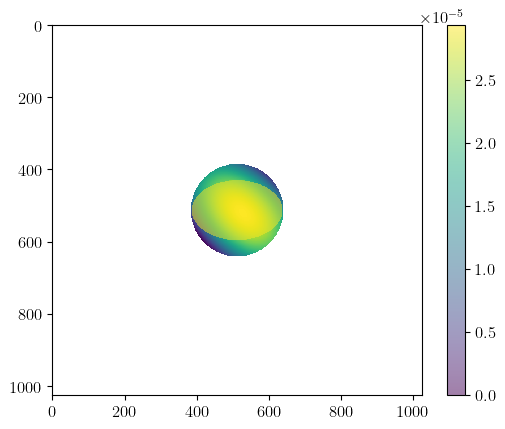

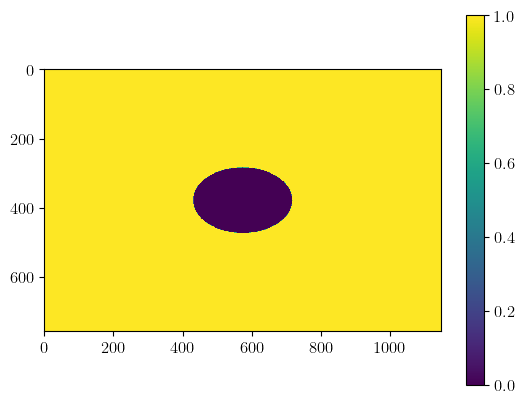

Sum of wfe:  1.9025694787001765e-06
Sum of wfe after mask:  3.9501582313044445e-06


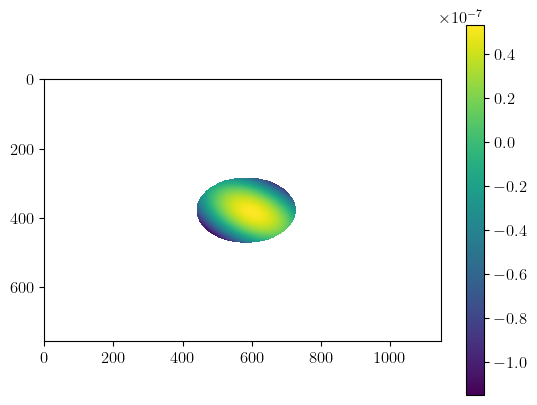

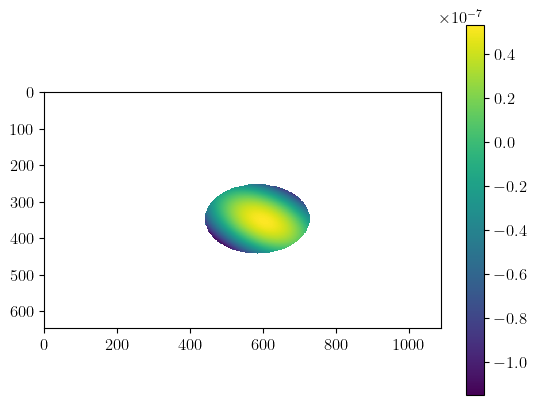

In [23]:
# change the WFE sampling when saving
scale_x = 1.11977
scale_y = 0.73901
# scale_x = 1
# scale_y = 1

plt.figure()
plt.imshow(wfe, interpolation="none")
ima = np.ma.masked_array(
    data=retval1[0]["amplitude"] ** 2, mask=retval1[0]["amplitude"] <= 0.0
)
plt.imshow(ima, alpha=0.5)
plt.colorbar()
plt.show()

mask = rescale(
    wfe.mask.astype(float),
    scale=(scale_y, scale_x),
    anti_aliasing=(
        scale_x < 1.0 or scale_y < 1.0
    ),  # anti_aliasing is required for downsampling
    order=3,
)

plt.figure()
plt.imshow(mask, interpolation="none")
plt.colorbar()
plt.show()

mask = mask > 0.5

wfe = rescale(
    wfe,
    scale=(scale_y, scale_x),
    anti_aliasing=(
        scale_x < 1.0 or scale_y < 1.0
    ),  # anti_aliasing is required for downsampling
    order=3,
)

wfe1 = wfe.copy()
print("Sum of wfe: ", np.sum(wfe1))

wfe = np.ma.MaskedArray(wfe, mask=mask)
print("Sum of wfe after mask: ", np.sum(wfe))

# shift the WFE by n pixels on both axes
# shift = (-101, 79)  # (yshift, xshift)
shift = (10, 0)  # (yshift, xshift)
wfe = np.roll(wfe, shift, axis=(1, 0))

plt.figure()
plt.imshow(wfe, interpolation="none")
plt.colorbar()
plt.show()

# crop the edges
wfe_shape = wfe.shape
crop_left = 0
crop_right = 60
crop_top = 30
crop_bottom = 80
wfe = wfe[
    crop_top : wfe_shape[0] - crop_bottom,
    crop_left : wfe_shape[1] - crop_right,
]

plt.figure()
plt.imshow(wfe, interpolation="none")
plt.colorbar()
plt.show()

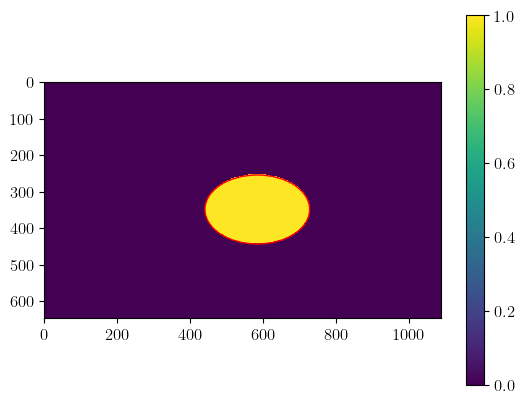

In [24]:
label_wfe = label(~wfe.mask)
props = regionprops(label_wfe)
params = mask_to_elliptical_aperture(label_wfe)

from photutils.aperture import EllipticalAperture

ellipse = EllipticalAperture(
    (params["x0"], params["y0"]),
    a=params["a"],
    b=params["b"],
    theta=params["theta"],
)

plt.figure()
plt.imshow(label_wfe, interpolation="none")
ellipse.plot(color="r", lw=1)
plt.colorbar()
plt.show()

In [25]:
out_dict = {
    # "data": wfe.filled(0.0) * 1.0e9,
    # "data": wfe.filled(np.nan) * 1.0e9,
    "data": wfe * 1.0e9,
    # data is in nm
    # "nx": params["a"] * 2,  # measured values
    # "ny": params["b"] * 2,
    "nx": grid_size / zoom * scale_x,
    "ny": grid_size / zoom * scale_y,
    "delx": wfo_dx / scale_x,
    "dely": wfo_dy / scale_y,
    # "xdec": params["y0"] - wfe.shape[0] / 2,  # measured values
    # "ydec": params["x0"] - wfe.shape[1] / 2,
    "xdec": shift[1] - (crop_top - crop_bottom) / 2,
    "ydec": shift[0] - (crop_left - crop_right) / 2,
}
np.save("sag.npy", out_dict)

print(wfe.shape)

(647, 1087)


In [26]:
params["y0"] - wfe.shape[0] / 2, shift[1] - (crop_top - crop_bottom) / 2, params[
    "x0"
] - wfe.shape[1] / 2, shift[0] - (crop_left - crop_right) / 2

(24.876622766861544, 25.0, 40.05285583491798, 40.0)

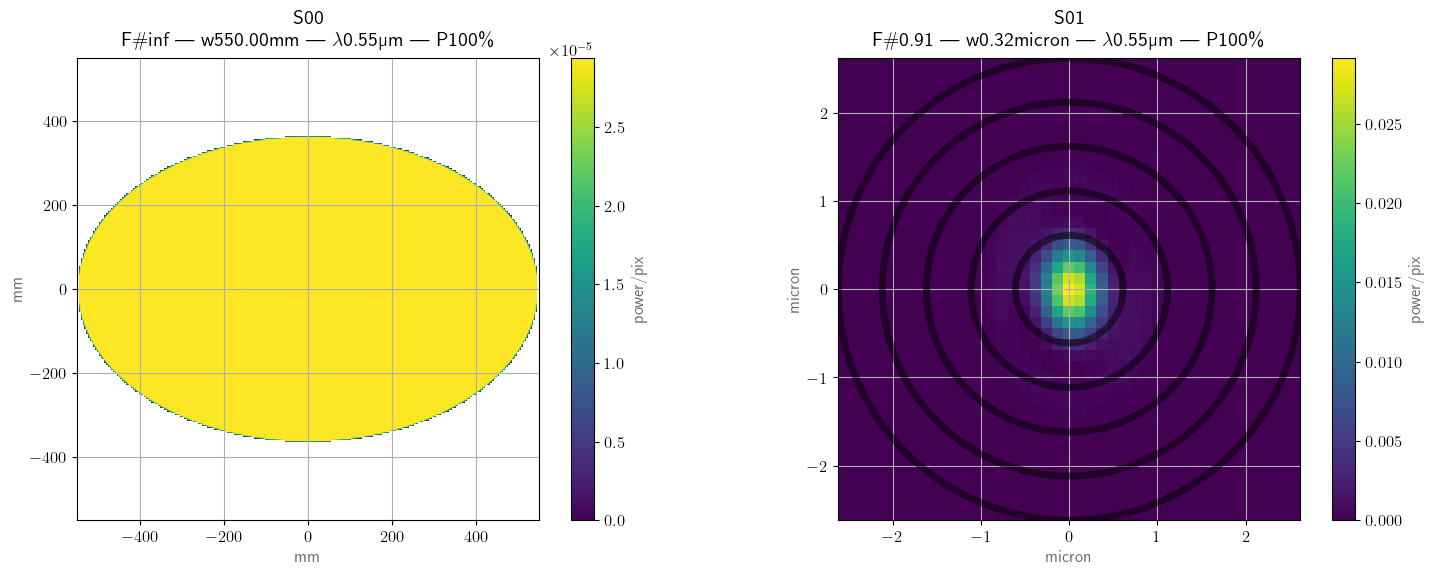

WFE RMS: 37.30 nm
WFE PV: 168.44 nm


In [27]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

simple_plot(fig, ax0, key=0, item=retval1[0], ima_scale="linear")
simple_plot(fig, ax1, key=1, item=retval1[1], ima_scale="linear")
plt.show()

print(f"WFE RMS: {1e9 * np.std(wfe):.2f} nm")
print(f"WFE PV: {1e9 * np.ptp(wfe):.2f} nm")

Now take the saved grid sag and let's see if we can reposition it and resize it to the original values. The check is done at the output PSF.


In [28]:
wfo = WFO(beam_diameter, 1.0e-6 * wavelength, grid_size, zoom)
wfo.aperture(
    xc=xdec,
    yc=ydec,
    hx=semimaj,
    hy=semimin,
    shape="elliptical",
)
wfo.make_stop()

data = np.load("sag.npy", allow_pickle=True).item()
sag, nx, ny, delx, dely, xdec, ydec = (
    data["data"],
    data["nx"],
    data["ny"],
    data["delx"],
    data["dely"],
    data["xdec"],
    data["ydec"],
)
# nx = None
# ny = None
sag *= 1.0e-9
# print(sag.mean())

sag = wfo.grid_sag(sag, nx, ny, delx, dely, xdec, ydec)

retval2 = {}
retval2[0] = push_results(wfo)
retval2[0]["aperture"] = None
retval2[0]["ABCDt"] = lambda: None

wfo.lens(lens_fl=lens_fl)
wfo.propagate(dz=dz)

retval2[1] = push_results(wfo)
retval2[1]["aperture"] = None
retval2[1]["ABCDt"] = lambda: None

2025-04-19 14:43:51.052 | DEBUG    | paos.classes.wfo:grid_sag:697 - Converting sag to masked array
2025-04-19 14:43:51.053 | DEBUG    | paos.classes.wfo:grid_sag:699 - Input sag is already a masked array
2025-04-19 14:43:51.056 | DEBUG    | paos.classes.wfo:grid_sag:710 - Applying sag shift: xdec = 25.000000, ydec = 40.000000
2025-04-19 14:43:51.239 | DEBUG    | paos.classes.wfo:grid_sag:729 - target width: 1147, target height: 757
2025-04-19 14:43:51.239 | DEBUG    | paos.classes.wfo:grid_sag:732 - current width: 1087, current height: 647
2025-04-19 14:43:51.239 | DEBUG    | paos.classes.wfo:grid_sag:745 - Applying padding on width...
2025-04-19 14:43:51.243 | DEBUG    | paos.classes.wfo:grid_sag:780 - Applying padding on height...
2025-04-19 14:43:51.245 | DEBUG    | paos.classes.wfo:grid_sag:807 - Adjusted sag shape is (757, 1147), mask shape is (757, 1147)
2025-04-19 14:43:51.378 | DEBUG    | paos.classes.wfo:grid_sag:836 - Resampled sag shape is (1024, 1024)
2025-04-19 14:43:51.4

(1024, 1024)


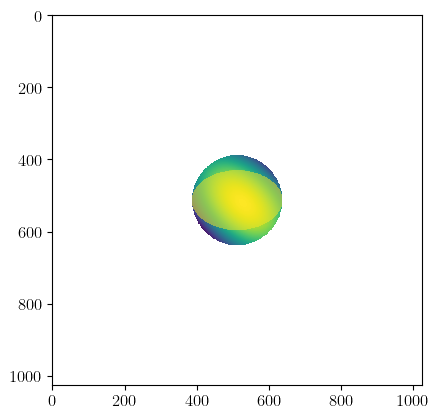

In [29]:
plt.figure()
plt.imshow(sag)
ima = np.ma.masked_array(
    data=retval2[0]["amplitude"] ** 2, mask=retval2[0]["amplitude"] <= 0.0
)
plt.imshow(ima, alpha=0.5)
print(sag.shape)
plt.show()

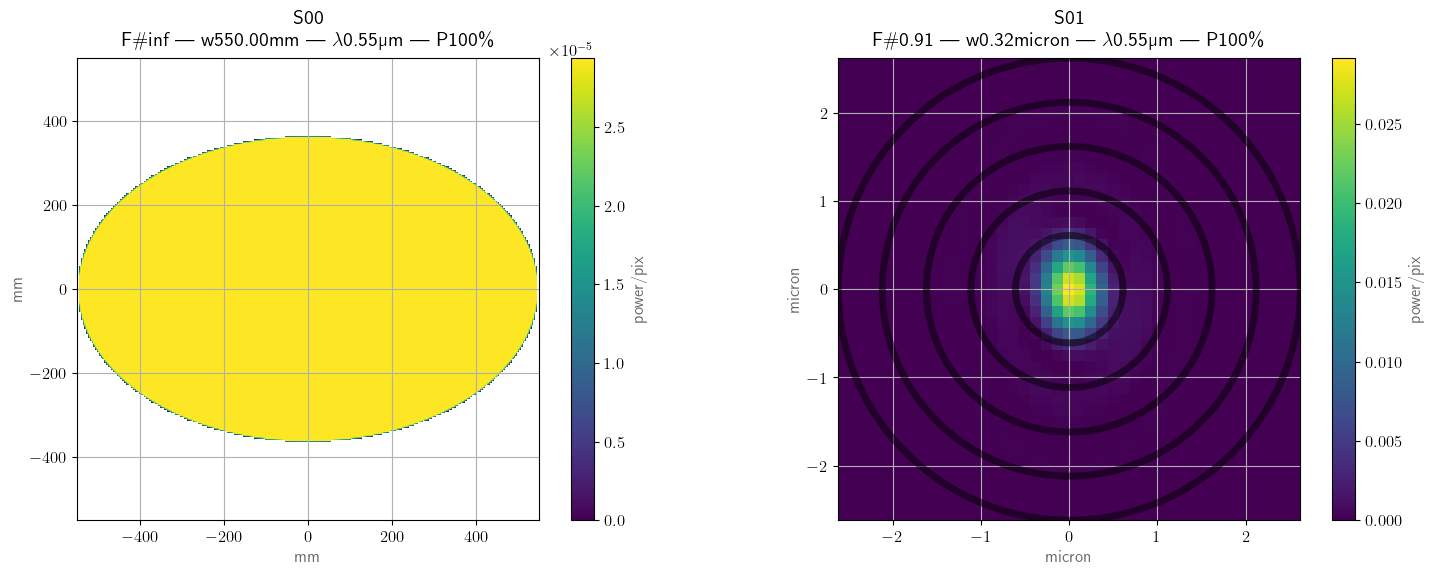

WFE RMS: 37.19 nm
WFE PV: 168.44 nm


In [30]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

simple_plot(fig, ax0, key=0, item=retval2[0], ima_scale="linear")
simple_plot(fig, ax1, key=1, item=retval2[1], ima_scale="linear")
plt.show()

print(f"WFE RMS: {1e9 * np.std(sag):.2f} nm")
print(f"WFE PV: {1e9 * np.ptp(sag):.2f} nm")

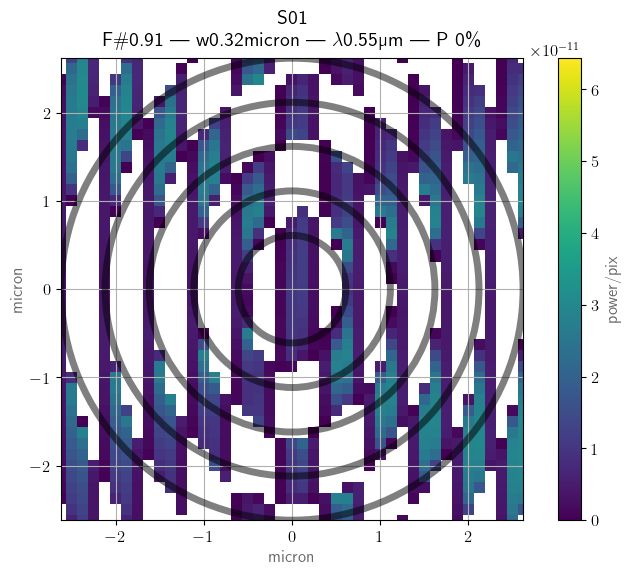

In [31]:
retval_diff = deepcopy(retval2)

amp1 = retval1[1]["amplitude"]
amp2 = retval2[1]["amplitude"]
retval_diff[1]["amplitude"] = amp1 - amp2

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
simple_plot(fig, ax0, key=1, item=retval_diff[1], ima_scale="linear")
plt.show()

Now use the run function directly in the paos run call


In [32]:
OpticalPrescription = "test_Grid_Sag.ini"
OpticalPrescriptionFile = os.path.join("../lens data", OpticalPrescription)
pup_diameter, parameters, wavelengths, fields, opt_chains = parse_config(
    OpticalPrescriptionFile
)
parameters["zoom"] = zoom
retval3 = run(
    pup_diameter,
    1.0e-6 * wavelengths[0],
    parameters["grid_size"],
    parameters["zoom"],
    fields[0],
    opt_chains[0],
)

2025-04-19 14:43:52.179 | DEBUG    | paos.util.material:__init__:33 - Using default library of optical materials
2025-04-19 14:43:52.183 | DEBUG    | paos.core.parseConfig:input_params:239 - Setting nx from grid_sag file: 286.66112
2025-04-19 14:43:52.183 | DEBUG    | paos.core.parseConfig:input_params:239 - Setting ny from grid_sag file: 189.18656
2025-04-19 14:43:52.184 | DEBUG    | paos.core.parseConfig:input_params:239 - Setting delx from grid_sag file: 0.003837283549300303
2025-04-19 14:43:52.185 | DEBUG    | paos.core.parseConfig:input_params:239 - Setting dely from grid_sag file: 0.0058143665173678305
2025-04-19 14:43:52.186 | DEBUG    | paos.core.parseConfig:input_params:239 - Setting xdec from grid_sag file: 25.0
2025-04-19 14:43:52.186 | DEBUG    | paos.core.parseConfig:input_params:239 - Setting ydec from grid_sag file: 40.0
2025-04-19 14:43:52.189 | DEBUG    | paos.util.material:__init__:33 - Using default library of optical materials
2025-04-19 14:43:52.191 | DEBUG    | pa

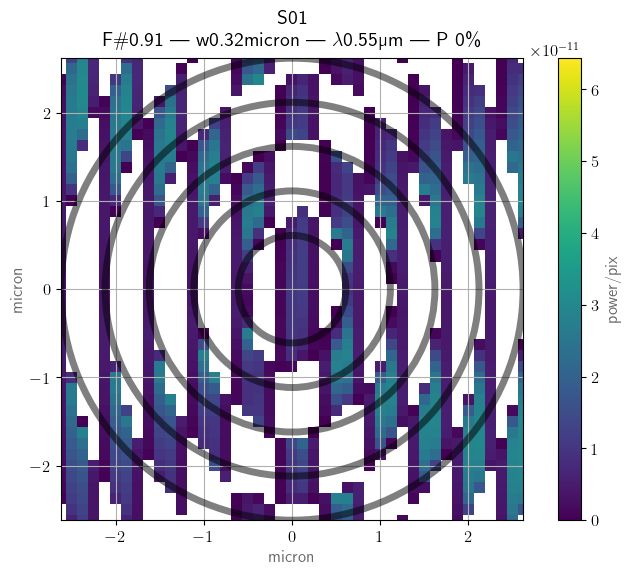

In [33]:
retval_diff = deepcopy(retval1)

amp1 = retval1[1]["amplitude"]
amp3 = retval3[5]["amplitude"]
retval_diff[1]["amplitude"] = amp1 - amp3

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))
simple_plot(fig, ax0, key=1, item=retval_diff[1], ima_scale="linear")
plt.show()

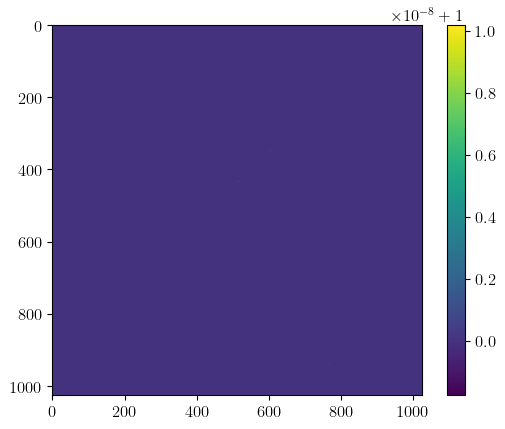

In [34]:
plt.imshow((amp1 - amp2) / (amp1 - amp3))
plt.colorbar()